In [1]:
import pickle as pickle
import string

import numpy as np
import scipy as sp
from scipy.spatial.distance import pdist, cdist, squareform

import pandas as pd

vocabFname = './embeddings/wordDict.npy'
mmapVecsFname = './embeddings/wordVecs.npy'
stopWordsFname = './embeddings/stop_words.txt'

with open(vocabFname, 'rb') as file:
    vocabDict = pickle.load(file)

idxToVocab = {vocabDict[i]: i for i in vocabDict}

wordVecs = np.load(mmapVecsFname, mmap_mode='r')

In [2]:
###########################################
###########################################
##
## Import text data
##

"""
We start out by impprting the text data, and then
tokenize each question and answer into multiword phrases 
from the pretrained word embeddings.
"""

df_text = pd.read_pickle('./scrape_scripts/abbyText.pickle')

In [3]:
# loading stopwords into a set
stop = set(['_', ''])
for line in open(stopWordsFname, 'rt'):
    line = line.strip()
    if line != '':
        stop.add(line)

# Set up a xtranslation table fro strip out punctuation
transTable = {ord(i): None for i in string.punctuation}

In [4]:
# This function will tokenize a string by spaces, and then merged adjacent tokens into
# multi-word phrases is they're in the vocab.

def tokenizeStr(inputString, vocabDict=vocabDict, stop=stop, transTable=transTable):
    # preprocess input string, tokenize on whitespace
    tokList = inputString.strip().translate(transTable).lower().split()
    
    # replace words with tokens in vocab, with detection of multiword phrases
    phraseList = []
    for phrLen in range(4, 0, -1):
        for i in range(0, len(tokList) - phrLen):
            tmpPhrase = '_'.join(tokList[i:(i + phrLen)])
            if tmpPhrase in vocabDict:
                tokList[i:(i + phrLen)] = [''] * phrLen
                if tmpPhrase not in stop:
                    phraseList.append(tmpPhrase)
    return phraseList

# Add tokenized text in a new column
df_text['phrase_text'] = df_text.parse_text.apply(lambda x: [list(map(tokenizeStr, p)) for p in x])

In [5]:
# For this demonstration, we're using a new dataframe that only
# contains user questions and none of Abby's answers

df_Q = {'text':[], 'phrases':[]}
for i in df_text.iterrows():
    df_Q['text'] += [j[0] for j in i[1].parse_text]
    df_Q['phrases'] += [j[0] for j in i[1].phrase_text]
df_Q = pd.DataFrame(df_Q)

In [6]:
# Utility function that returns an array of word embeddings
# given a list of tokens
def __getEmbedVecs(r, vocabDict=vocabDict):
    idx = [vocabDict[t] for t in r.phrases]
    return wordVecs[idx, :]


# Get a batch document similarities using average w2v embeddings
# between a target-doc (row1)  and a corpus of docs
# to search through (rows2).
# Both row1 and rows2 are rows from a pandas dataframes

def getEmbedSimilarities_avg(row1, rows2):
    r1_vec = __getEmbedVecs(row1)
    r1_vec_mean = np.mean(r1_vec, axis=0)
    r1_vec_mean /= np.linalg.norm(r1_vec_mean)
    
    avgSims = []
    for i in range(rows2.shape[0]):
        r2_vec = __getEmbedVecs(rows2.iloc[i,:])
        r2_vec_mean = np.mean(r2_vec, axis=0)
        r2_vec_mean /= np.linalg.norm(r2_vec_mean)

        avgSims += [np.sum(r1_vec_mean*r2_vec_mean)]
    return avgSims



# Utility function that calculates the 'overlap' between
# two sets of RBF functions
def __btwnMag(doc1, doc2=None, sigma=1.0):
    if doc2 is not None:
        dist = cdist(doc1, doc2, metric='sqeuclidean')
    else:
        dist = squareform(pdist(doc1, metric='sqeuclidean'))
    dist = np.exp(-sigma * dist)
    mag = np.mean(dist.ravel())
    return mag


# Calculate the document similarity using 'Bag of Embeddings'
def BoE_dist(doc1, doc2, s=1.0):
    m1 = __btwnMag(doc1, sigma=s)
    m2 = __btwnMag(doc2, sigma=s)
    bw = __btwnMag(doc1, doc2=doc2, sigma=s)
    return bw / np.sqrt((m1 * m2))


# Get a batch of BoE similarities given a target-doc (row1) 
# and a corpus of docs to search through (rows2).
# Both row1 and rows2 are rows from a pandas dataframe
def getEmbedSimilarities_boe(row1, rows2, s=1.0):
    r1_vec = __getEmbedVecs(row1)
    n1 = r1_vec.shape[0]
    boeSims = []
    for i in range(rows2.shape[0]):
        r2_vec = __getEmbedVecs(rows2.iloc[i,:])
        n2 = r2_vec.shape[0]
        boeSims += [BoE_dist(r1_vec, r2_vec, s=s)]
    return boeSims

In [7]:
# find one question to serve as a 'seed' for searching

seed_question = df_Q.iloc[50]
print('SEED QUESTION:\n\n{}'.format(seed_question.text))

SEED QUESTION:

ABBY: I have a BIG problem. I am getting married on Nov. 23. My fiance and I are having a wedding reception with more than 200 guests. There are NO children invited. According to the etiquette books that I have read, it is not proper to put "No Children" on your wedding invitations. (Mine are already printed up the proper way.) Anyway, one of my aunts is upset because her son and his wife have a 2-year-old boy who has cerebral palsy and some mental retardation. They claim that they cannot get a baby sitter for the boy and that they are bringing him to the wedding. They brought him to a family wedding last year, and everyone was buzzing about it. I don't understand why they can't get a sitter. They have plenty of time to find one. And I don't want you to think that we don't want the boy there because he has a disability. (My fiance also has a physical disability.) But it is not fair to my fiance's family, some of whom have small children, too. How do I handle this? I hav

In [8]:
# Measure the similarity of the seed question to every other question
# and rank them by most-similar

# BoE similarities are calcualted with 3 different 'sigmas' that
# represent the precision (i.e., inverse variance) of underlying RBF representation

df_Q['avg_sim'] = getEmbedSimilarities_avg(seed_question, df_Q)
df_Q['boe_s1_sim'] = getEmbedSimilarities_boe(seed_question, df_Q, s=1.0)
df_Q['boe_s01_sim'] = getEmbedSimilarities_boe(seed_question, df_Q, s=0.1)
df_Q['boe_s10_sim'] = getEmbedSimilarities_boe(seed_question, df_Q, s=10.0)

df_Q['avg_sim_rank'] = df_Q['avg_sim'].rank(ascending=False)
df_Q['boe_s1_sim_rank'] = df_Q['boe_s1_sim'].rank(ascending=False)
df_Q['boe_s01_sim_rank'] = df_Q['boe_s01_sim'].rank(ascending=False)
df_Q['boe_s10_sim_rank'] = df_Q['boe_s10_sim'].rank(ascending=False)

In [9]:
nToKeep = 5

print('Most similar according to avg w2v embedding')
for i in df_Q.nlargest(nToKeep, 'avg_sim').iterrows():
    print('{}\n'.format(i[1].text))

Most similar according to avg w2v embedding
ABBY: I have a BIG problem. I am getting married on Nov. 23. My fiance and I are having a wedding reception with more than 200 guests. There are NO children invited. According to the etiquette books that I have read, it is not proper to put "No Children" on your wedding invitations. (Mine are already printed up the proper way.) Anyway, one of my aunts is upset because her son and his wife have a 2-year-old boy who has cerebral palsy and some mental retardation. They claim that they cannot get a baby sitter for the boy and that they are bringing him to the wedding. They brought him to a family wedding last year, and everyone was buzzing about it. I don't understand why they can't get a sitter. They have plenty of time to find one. And I don't want you to think that we don't want the boy there because he has a disability. (My fiance also has a physical disability.) But it is not fair to my fiance's family, some of whom have small children, too.

In [10]:
print('Most similar according to BoE embedding')
for i in df_Q.nlargest(nToKeep, 'boe_s1_sim').iterrows():
    print('{}\n'.format(i[1].text))

Most similar according to BoE embedding
ABBY: I have a BIG problem. I am getting married on Nov. 23. My fiance and I are having a wedding reception with more than 200 guests. There are NO children invited. According to the etiquette books that I have read, it is not proper to put "No Children" on your wedding invitations. (Mine are already printed up the proper way.) Anyway, one of my aunts is upset because her son and his wife have a 2-year-old boy who has cerebral palsy and some mental retardation. They claim that they cannot get a baby sitter for the boy and that they are bringing him to the wedding. They brought him to a family wedding last year, and everyone was buzzing about it. I don't understand why they can't get a sitter. They have plenty of time to find one. And I don't want you to think that we don't want the boy there because he has a disability. (My fiance also has a physical disability.) But it is not fair to my fiance's family, some of whom have small children, too. How

In [11]:
import matplotlib.pyplot as plt
%matplotlib nbagg

import seaborn as sb

<IPython.core.display.Javascript object>


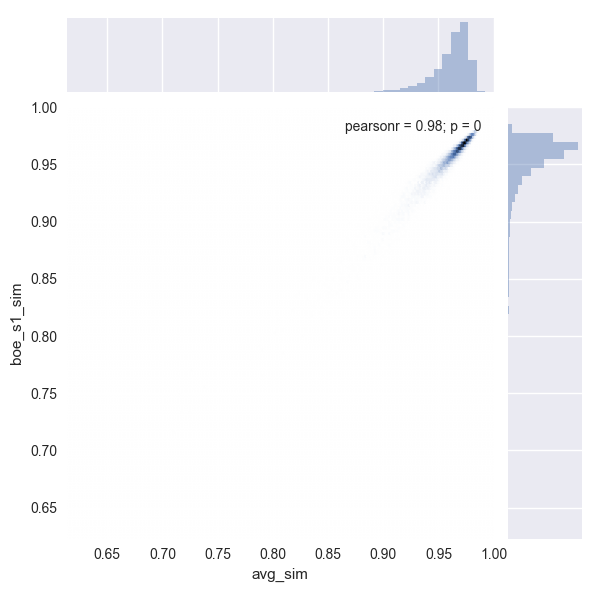

In [12]:
sb.jointplot('avg_sim', 'boe_s1_sim', data=df_Q, kind='hex')

<IPython.core.display.Javascript object>


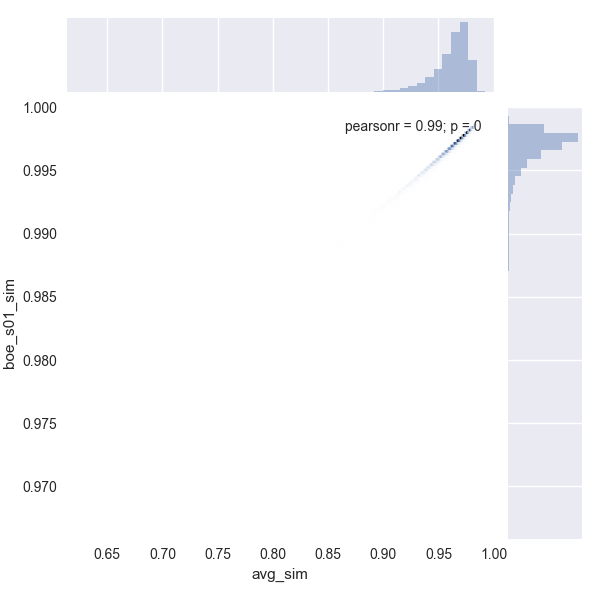

In [13]:
sb.jointplot('avg_sim', 'boe_s01_sim', data=df_Q, kind='hex')

<IPython.core.display.Javascript object>


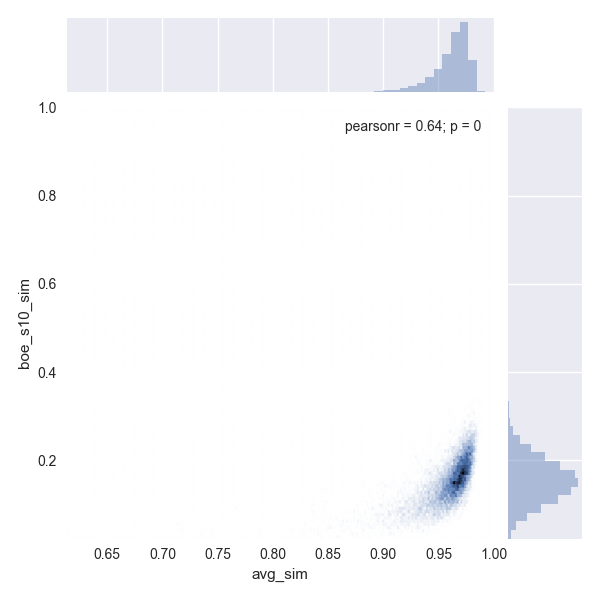

In [14]:
sb.jointplot('avg_sim', 'boe_s10_sim', data=df_Q, kind='hex')

<IPython.core.display.Javascript object>


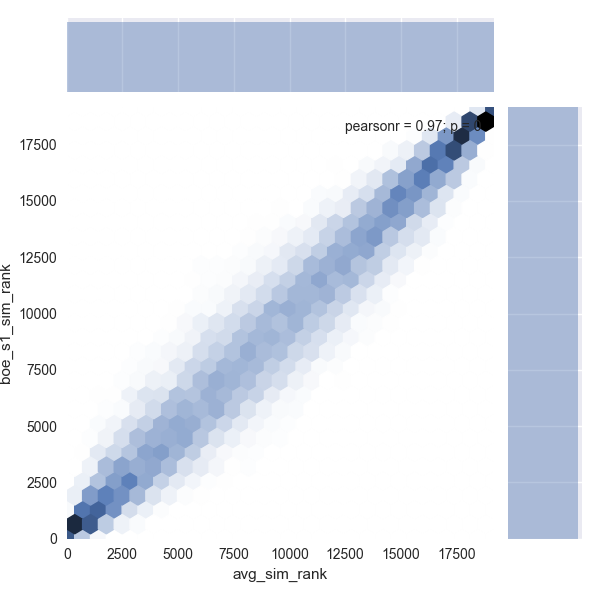

In [15]:
sb.jointplot('avg_sim_rank', 'boe_s1_sim_rank', data=df_Q, kind='hex')

<IPython.core.display.Javascript object>


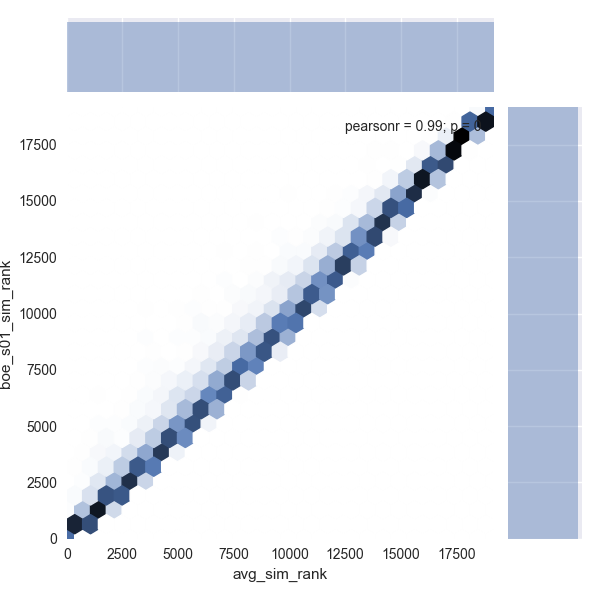

In [16]:
sb.jointplot('avg_sim_rank', 'boe_s01_sim_rank', data=df_Q, kind='hex')

<IPython.core.display.Javascript object>


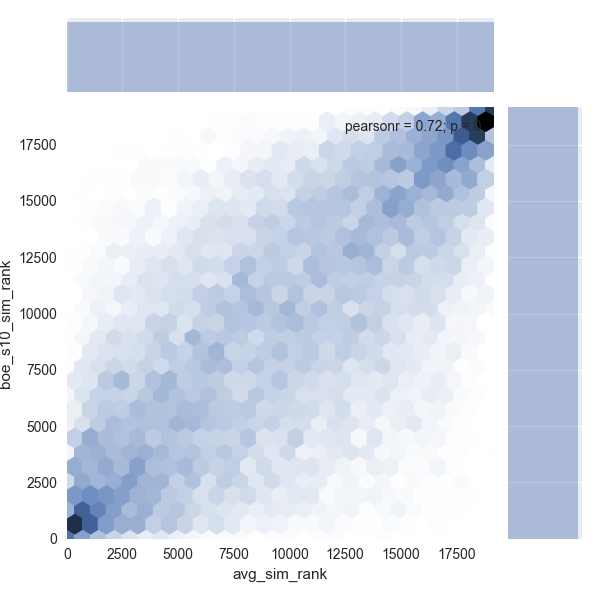

In [17]:
sb.jointplot('avg_sim_rank', 'boe_s10_sim_rank', data=df_Q, kind='hex')